In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
## DATA ##

file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastspec-everest-main-bright.fits"
data=Table.read(file_path,hdu=1)

In [3]:
## getting good data of size n
N=data["TARGETID"].size
file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastphot-everest-main-bright.fits"
data2=Table.read(file_path,hdu=1)
data3=Table.read(file_path,hdu=2)
n=50*10**3
positions=[]
magnitude_names=["FLUX_G","FLUX_R","FLUX_Z","FLUX_W1","FLUX_W2"]
checking_magnitudes=data3[magnitude_names]
for i in range(N):
    k=0
    # if data["HALPHA_EW"][i]==0:
    #     k+=1
    for j in range(len(magnitude_names)):
        if checking_magnitudes[i][j]==0:
            k+=1
    if k==0:
        positions.append(i)
print(len(positions))

#magnitude_names=["FLUX_SYNTH_MODEL_G","FLUX_SYNTH_MODEL_R","FLUX_SYNTH_MODEL_Z","FLUX_SYNTH_MODEL_W1","FLUX_SYNTH_MODEL_W2"]
#magnitude_names=["KCORR_SDSS_U","KCORR_SDSS_G","KCORR_SDSS_R","KCORR_SDSS_I","KCORR_SDSS_Z","KCORR_W1"]

#magnitude_names=["ABSMAG_SDSS_U","ABSMAG_SDSS_G","ABSMAG_SDSS_R","ABSMAG_SDSS_I","ABSMAG_SDSS_Z"]
#jj=random.sample(range(0,len(positions)),n)
jj=np.arange(n)
z=np.zeros(n)
magnitudes=np.zeros([n,len(magnitude_names)])

for i in range(n):
    z[i]=data["CONTINUUM_Z"][positions[jj[i]]]
    for j in range(len(magnitude_names)):
        magnitudes[i,j]=data3[magnitude_names[j]][positions[jj[i]]]

1088377


In [4]:
x=np.zeros([n,len(magnitude_names)])
for i in range(n):
    for j in range(len(magnitude_names)-1):
        x[i,j]=magnitudes[i,j]/magnitudes[i,j+1]
    x[i,-1]=magnitudes[i,1]

av_x=np.zeros(x.shape[1]-1)
std_x=np.zeros(x.shape[1]-1)
for i in range(1,x.shape[1]):
    av_x[i-1]=np.average(x[:,i])
    std_x[i-1]=np.std(x[:,i])
    x[:,i]=(x[:,i]-av_x[i-1])/std_x[i-1]

model=RandomForestRegressor()

N_cv=10
x_split=np.split(x,N_cv)
z_split=np.split(z,N_cv)
z_fit_all=[]
z_obs_all=[]
spearman_all=[]
rms_all=[]
nmad_all=[]
for i in range(N_cv):
    x_valid=x_split[i]
    z_valid=z_split[i]
    x_to_combine=[]
    z_to_combine=[]
    for j in range(N_cv):
        if j!=i:
            x_to_combine.append(x_split[j])
            z_to_combine.append(z_split[j])
    x_train=np.concatenate(tuple(x_to_combine),axis=0)
    z_train=np.concatenate(tuple(z_to_combine),axis=0)
    nl=100
    tree=KDTree(x_train[:,:])
    dist, ind=tree.query(x_valid[:,:],k=nl)
    
    zeros=np.where(dist==0)[0]
    print(zeros)
    dist=np.delete(dist,obj=zeros,axis=0)
    ind=np.delete(ind,obj=zeros,axis=0)
    x_valid=np.delete(x_valid,obj=zeros,axis=0)
    z_valid=np.delete(z_valid,obj=zeros,axis=0)
    
    n_valid=x_valid.shape[0]
    theta=np.zeros([n_valid,x.shape[1],1])
    W=np.zeros([n_valid,nl,nl])
    X=np.zeros([n_valid,nl,x.shape[1]])
    Y=np.zeros([n_valid,nl,1])
    for j in range(nl):
        W[:,j,j]=1/dist[:,j]
        #W[:,j,j]=1
        #W[:,j,j]=np.exp(-dist[:,j]/alpha)
        X[:,j,:]=x_train[ind[:,j],:]
        Y[:,j,0]=z_train[ind[:,j]]
    a1=np.zeros([n_valid,x.shape[1],1])
    a2=np.zeros([n_valid,x.shape[1],x.shape[1]])
    
    for ii in range(n_valid):
        a1[ii,:,:]=np.matmul(X[ii,:,:].transpose(),np.matmul(W[ii,:,:],Y[ii,:,:]))
        a2[ii,:,:]=np.matmul(X[ii,:,:].transpose(),np.matmul(W[ii,:,:],X[ii,:,:]))
        theta[ii,:,:]=np.matmul(np.linalg.inv(a2[ii,:,:]),a1[ii,:,:])
    z_fit=np.zeros(n_valid)
    z_used=np.zeros(n_valid)
    nmad=np.zeros(n_valid)
    for ii in range(n_valid):
        z_fit[ii]=np.matmul(theta[ii,:,:].transpose(),x_valid[ii,:])
        z_used[ii]=z_valid[ii]
        nmad[ii]=np.abs(z_fit[ii]-z_used[ii])
    z_fit_all.append(z_fit)
    z_obs_all.append(z_used)
    spearman_all.append(stats.spearmanr(z_fit,z_used)[0])
    rms_all.append(np.sqrt(mean_squared_error(z_fit,z_used)))
    nmad_all.append(1.48*np.median(nmad))
    

print(spearman_all)
print(np.average(spearman_all))
print(rms_all)
print(np.average(rms_all))
print(nmad_all)
print(np.average(nmad_all))


with open("/global/homes/a/ashodkh/results/photo_z_fit_LLR.txt",'w') as f:
    for i in range(N_cv):
        for j in range(len(z_fit_all[i])-1):
            f.write(str(np.round(z_fit_all[i][j],decimals=5))+',')
        f.write(str(np.round(z_fit_all[i][-1],decimals=5)))
        f.write('\n')

with open("/global/homes/a/ashodkh/results/photo_z_obs_LLR.txt",'w') as f:
    for i in range(N_cv):
        for j in range(len(z_obs_all[i])-1):
            f.write(str(np.round(z_obs_all[i][j],decimals=5))+',')
        f.write(str(np.round(z_obs_all[i][-1],decimals=5)))
        f.write('\n')


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8660783293311329, 0.867152474718099, 0.8586798746671949, 0.8505032407081297, 0.8545486194299446, 0.8447246567009861, 0.836905102340204, 0.84880675033627, 0.8287555823342232, 0.8428597344183894]
0.8499014364984573
[0.08791870321351414, 0.10111902165287799, 0.1297784932381349, 0.13821169785980328, 0.13854805787309252, 0.2950936299215348, 0.14598504500002876, 0.136453430112666, 0.6834897975980437, 0.10011289142857617]
0.19567107678982726
[0.03739786677288428, 0.0386068358039583, 0.038339726578885486, 0.03752187913180463, 0.03887064147646696, 0.039274113588488375, 0.03848626905938033, 0.03902337517392499, 0.03923656980237504, 0.03784370813882239]
0.03846009855269907


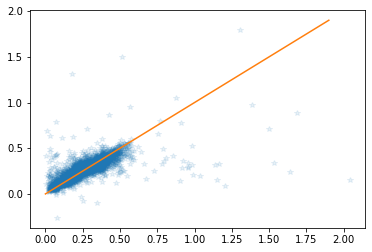

In [5]:
plt.plot(z_obs_all[0],z_fit_all[0],'*',alpha=0.1)
plt.plot(np.arange(0,2,0.1),np.arange(0,2,0.1))

In [6]:
print(spearman_all)

[0.8660783293311329, 0.867152474718099, 0.8586798746671949, 0.8505032407081297, 0.8545486194299446, 0.8447246567009861, 0.836905102340204, 0.84880675033627, 0.8287555823342232, 0.8428597344183894]
